In [1]:
import matplotlib.pyplot as plt
from spider import SPIDER
op = SPIDER()
import anndata
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import os

2023-09-22 18:30:39.529216: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 18:30:39.531898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 18:30:39.584100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 18:30:39.586871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 18:30:40.566740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
ds = 'mouse_lung'

Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
298/1919 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
546/1911 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
694/1903 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LR
(nnSVG)_E5 SVI vs. LR
(nnSVG)_E5 Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:7.858e-68 U_stat=1.838e+05
LR
(SOMDE)_E5 SVI vs. LR
(SOMDE)_E5 

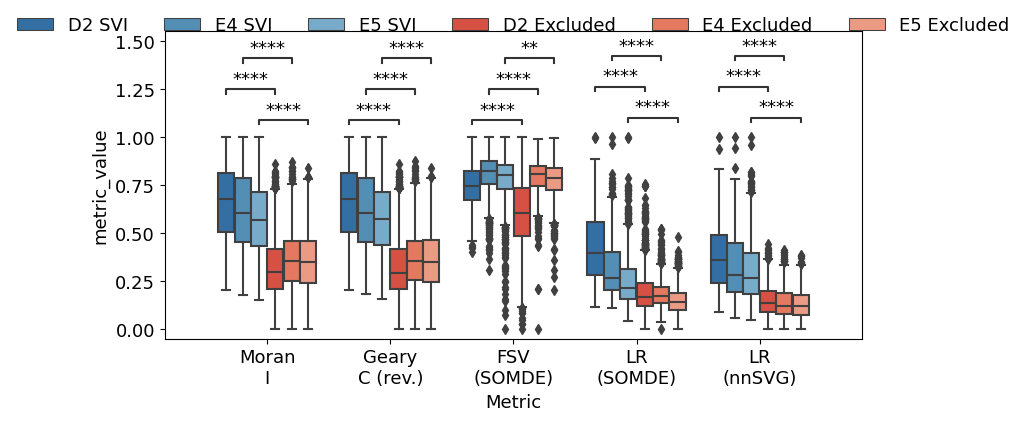

In [17]:
ds = 'mouse_lung'
boxdf = []
for sample_name in os.listdir(f'../datasets/{ds}/'):
    out_f = f'../input_datasets/{ds}/{sample_name}/'
    adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
    out_f = f'../datasets/{ds}/{sample_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    
    svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)
    methods = np.array(['moranI', 'gearyC', 'SOMDE', 'nnSVG'])[np.isin(['SOMDE', 'nnSVG', 'gearyC', 'moranI'],list(idata.uns.keys()))]
    print(f'evaluating with {methods}')
    dfs = []
    metrics = []
    for i in methods:
        if i == 'gearyC':
            dfs.append(-idata.uns['gearyC'][['C']])
            metrics.append("Geary\nC (rev.)")
        elif i == 'moranI':
            dfs.append(idata.uns['moranI'][['I']]),
            metrics.append("Moran\nI")
        elif i == 'SOMDE':
            dfs.append(idata.uns['SOMDE'].set_index('g')['FSV']),
            metrics.append("FSV\n(SOMDE)") 
            dfs.append(idata.uns['SOMDE'].set_index('g')['LLR']),
            metrics.append("LR\n(SOMDE)") 
        elif i == 'nnSVG':
            # dfs.append(idata.uns['nnSVG']['prop_sv']),
            # metrics.append("FSV\n(nnSVG)") 
            dfs.append(idata.uns['nnSVG']['LR_stat']),
            metrics.append("LR\n(nnSVG)") 
    df = pd.concat(dfs, axis=1)
    df.columns=metrics

    normalized_df=(df-df.min())/(df.max()-df.min())
    normalized_df['Category'] = f'{sample_name} Excluded'
    normalized_df.loc[svi_df_strict.index, 'Category'] = f'{sample_name} SVI'
    normalized_df = normalized_df.melt(id_vars='Category', value_vars=metrics, var_name='Metric')
    boxdf.append(normalized_df)

import seaborn as sns
from statannotations.Annotator import Annotator
sumdf=pd.concat(boxdf,axis=0)
pairs = []
for i in metrics:
    pairs.append( ((i, 'D2 SVI'), (i, 'D2 Excluded')) )
    pairs.append( ((i, 'E4 SVI'), (i, 'E4 Excluded')) )
    pairs.append( ((i, 'E5 SVI'), (i, 'E5 Excluded')) )
sumdf_copy = sumdf.copy().dropna()
sumdf['metric_value'] = sumdf['value'] 

plt.figure(figsize=(9, 4))
ax =sns.boxplot(data=sumdf,x='Metric',y='metric_value', hue='Category', palette={
    'D2 SVI':'#2171b5','E4 SVI':'#4292c6','E5 SVI':'#6baed6',
    'D2 Excluded': '#ef3b2c','E4 Excluded': '#fb6a4a','E5 Excluded': '#fc9272',
}, width=0.8, hue_order=['D2 SVI', 'E4 SVI','E5 SVI','D2 Excluded', 'E4 Excluded','E5 Excluded',])
ax.legend(loc='upper center',ncol=6, bbox_to_anchor=(0.5, 1.1), frameon=False)
annot = Annotator(ax, pairs, data=sumdf, x='Metric',y='value', hue='Category', hue_order=['D2 SVI', 'E4 SVI','E5 SVI','D2 Excluded', 'E4 Excluded','E5 Excluded',])
annot.configure(test='Mann-Whitney-gt',comparisons_correction="BH", correction_format="replace")
annot.apply_test()
annot.annotate()
plt.savefig(f'../figures/mouse_lung_metric.png', dpi=300,bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LR
(nnSVG)_E5 SVI vs. LR
(nnSVG)_E5 Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:7.858e-68 U_stat=1.838e+05
LR
(SOMDE)_E5 SVI vs. LR
(SOMDE)_E5 Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:3.329e-75 U_stat=6.308e+05
LR
(nnSVG)_D2 SVI vs. LR
(nnSVG)_D2 Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:1.368e-84 U_stat=1.784e+05
Moran
I_E5 SVI vs. Moran
I_E5 Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:9.479e-103 U_stat=6.675e+05
Moran
I_D2 SVI vs. Moran
I_D2 Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:5.358e-97 U_stat=4.250e+05
Moran
I_E4 SVI vs. Moran
I_E4 Excluded: Mann-Whitney-Wilcoxon test greater with 

(<AxesSubplot: ylabel='Normalized metric values'>,
  <statannotations.Annotation.Annotation at 0x7fe5cdda9250>])

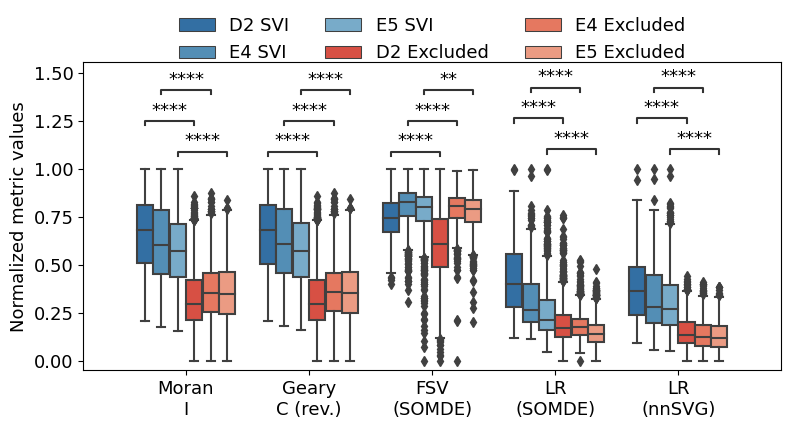

In [18]:
plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 13})
ax =sns.boxplot(data=sumdf,x='Metric',y='metric_value', hue='Category', palette={
    'D2 SVI':'#2171b5','E4 SVI':'#4292c6','E5 SVI':'#6baed6',
    'D2 Excluded': '#ef3b2c','E4 Excluded': '#fb6a4a','E5 Excluded': '#fc9272',
}, width=0.8, hue_order=['D2 SVI', 'E4 SVI','E5 SVI','D2 Excluded', 'E4 Excluded','E5 Excluded',])
plt.xlabel('')
plt.ylabel('Normalized metric values')
ax.legend(loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.2), frameon=False)
annot = Annotator(ax, pairs, data=sumdf, x='Metric',y='value', hue='Category', hue_order=['D2 SVI', 'E4 SVI','E5 SVI','D2 Excluded', 'E4 Excluded','E5 Excluded',])
annot.configure(test='Mann-Whitney-gt',comparisons_correction="BH", correction_format="replace")
annot.apply_test()
annot.annotate()

In [3]:
ds = 'mouse_lung'
for sample_name in ['E4', 'E5']:
# for sample_name in os.listdir(f'../datasets/{ds}/'):
    out_f = f'../input_datasets/{ds}/{sample_name}/'
    adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
    out_f = f'../datasets/{ds}/{sample_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    
    svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)
    # op.svi.eva_SVI(idata, svi_df_strict)
    # plt.savefig(f'../figures/{ds}_{sample_name}_metric.png', dpi=300,bbox_inches='tight')
    # plt.close()
    

    sq.gr.spatial_neighbors(adata, key_added='spatial')
    sq.gr.spatial_autocorr(
        adata,
        genes=adata.var_names,
        mode="moran",
        n_perms=1000,
        n_jobs=10,
    )
    plt.rcParams.update({'font.size': 10})
    merged_df,lri_pw_list,gene_lr_list,gene_pw_list = op.vis.svg_svi_relation(adata, idata, title=sample_name, is_human=adata.uns['is_human'], top=50)
    plt.savefig(f'../figures/{ds}_{sample_name}_relation.png', dpi=100,bbox_inches='tight')
    plt.close()
    
    # import gseapy
    # membership=pd.get_dummies(merged_df.set_index('Term')['group']).groupby('Term').sum().astype(str).agg('-'.join, axis=1)
    # merged_df['group name'] = membership.loc[merged_df.Term].to_numpy()
    # rename_dict = {
    #     '1-0-0': 'LR', '1-0-1':'SVI&LR', '0-0-1':'SVI', '1-1-1':'All', '0-1-0':'SVG', '0-1-1':'SVI&SVG'
    # }
    # merged_df['group name'] = merged_df['group name'] .astype('category').cat.rename_categories(rename_dict).to_numpy()
    # op.vis.enrichment(merged_df,x_key='group name', cutoff=0.05, top_term=20,size=15,save=f'../figures/{ds}_{sample_name}_relation_enrichment.png')
            
    # op.vis.pattern_LRI(idata,show_SVI=10, spot_size=1)
    # plt.tight_layout()
    # plt.savefig(f'../figures/{ds}_{sample_name}_patterns.png', dpi=100,bbox_inches='tight')
    # plt.close()

    # op.vis.pattern_LRI(idata,spot_size=1)
    # plt.tight_layout()
    # plt.savefig(f'../figures/{ds}_{sample_name}_patterns1.png', dpi=100,bbox_inches='tight')
    # plt.close()
    
    # plt.rcParams.update({'font.size': 11})
    # op.svi.eva_pattern(idata)
    # plt.savefig(f'../figures/{ds}_{sample_name}_pattern_metric.png', dpi=100,bbox_inches='tight')
    # plt.close()
    
    # merged_df_edge, arr = op.er.pattern_enrichment_edge(idata,is_human=adata.uns['is_human'])
    # merged_df_node, arr = op.er.pattern_enrichment_node(idata,is_human=adata.uns['is_human'])
    # op.vis.enrichment(merged_df_node,x_key='label', cutoff=0.05, top_term=20,save=f'../figures/{ds}_{sample_name}_pattern_enrichment_node.png',size=15)
    # try:
    #     op.vis.enrichment(merged_df_edge,x_key='label', cutoff=0.05, top_term=20,save=f'../figures/{ds}_{sample_name}_pattern_enrichment_edge.png')
    # except Exception as e:
    #     print(e)
    
    # idata = idata[:, idata.var['is_svi']==1]
    # adata.obs[['row', 'col']] = adata.obs[['row', 'col']].astype(int)
    # adata, adata_lri, adata_pattern = op.cell_transform(idata, adata, label=adata.uns['cluster_key'])
    # adata_lri.obs[['row', 'col']] = adata_lri.obs[['row', 'col']].astype(int)
    # adata_pattern.obs[['row', 'col']] = adata_pattern.obs[['row', 'col']].astype(int)
    
    
    # with plt.rc_context():
    #     sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', show=False, cmap='plasma')
    #     plt.savefig(f'../figures/{ds}_{sample_name}_label_SVI.png', bbox_inches="tight")
    #     plt.close()
        
    # with plt.rc_context():
    #     sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', n_genes=1, show=False, cmap='plasma')
    #     plt.savefig(f'../figures/{ds}_{sample_name}_label_SVI1.png', bbox_inches="tight")
    #     plt.close()
        
    # with plt.rc_context(): 
    #     sc.set_figure_params(figsize=(10,10))
    #     plt.rcParams.update({'font.size': 11})
    #     sc.pl.rank_genes_groups_dotplot(adata_pattern, standard_scale='var', n_genes=1, show=False, cmap='plasma')
    #     plt.savefig(f'../figures/{ds}_{sample_name}_label_pattern.png', bbox_inches="tight")
    #     plt.close()
        
    # from scipy import stats
    # pds = []
    # for i in adata_lri.var_names:
    #     pds.append(pd.get_dummies(adata.obs['annotation']).corrwith(adata_lri.to_df()[i].astype('float'), method=stats.pointbiserialr)[:1])
    # pds_df = pd.concat(pds)
    # pds_df.index = adata_lri.var_names
    # useful_df = []
    # # plt.rcParams.update({'font.size': 14})
    # for cluster_i in adata.obs['annotation'].unique():
    #     df_sub = pds_df[pds_df[cluster_i]>0.5][cluster_i].sort_values(ascending=False)
    #     if len(df_sub) > 0:
    #         useful_df.append(df_sub)
    #         markers = df_sub.index.to_numpy()[:10]
    #         corrs = df_sub.values[:10]
    #         cluster_name = df_sub.name
    #         plt.figure(figsize=(4*(len(markers)+1), 4))
    #         base = 1
    #         plt.subplot(1, len(markers)+1, base)

    #         plt.scatter(adata.obs['row'],adata.obs['col'], c=adata.obs['annotation']==cluster_i, s=0.5, cmap='plasma')
    #         plt.axis('equal')
    #         plt.axis('off')
    #         plt.title(f'{cluster_name}\n({sample_name})')
    #         base += 1

    #         marker_score = adata_lri.to_df()[markers]
    #         marker_score = pd.concat([adata_lri.obs[['row', 'col']], marker_score], axis=1)
    #         for i in range(len(markers)):
    #             plt.subplot(1, len(markers)+1, base)
    #             im=plt.scatter(marker_score['row'],marker_score['col'], c=marker_score[markers[i]], s=0.5, cmap='plasma')
    #             plt.colorbar(im,fraction=0.046, pad=0.04)
    #             plt.axis('equal')
    #             plt.axis('off')
    #             plt.title(f'{markers[i]}\ncorr={"%.3f" % corrs[i]}')
    #             base += 1
    #         plt.savefig(f'../figures/{ds}_{sample_name}_{cluster_name}.png', dpi=100,bbox_inches='tight')
    #         plt.close()    

    # corr_df = pd.concat([adata.to_df()[['Scgb1a1', 'Scgb3a2', 'Cyp2f2', 'Hp']].loc[adata_lri.obs_names], adata_lri.to_df()], axis=1).corr(method='pearson')
    # corr_df_asyn =  corr_df.loc[adata_lri.var_names, ['Scgb1a1', 'Scgb3a2', 'Cyp2f2', 'Hp']]
    # # plt.rcParams.update({'font.size': 15})

    # corrs = corr_df_asyn.mean(1).sort_values(ascending=False).values[:10]
    # lris = corr_df_asyn.mean(1).sort_values(ascending=False).index[:10]
    # marker_score = adata_lri.to_df()[lris]
    # adata.obs[['row', 'col']] = adata.obs[['row', 'col']].astype(int)
    # adata_lri.obs[['row', 'col']] = adata_lri.obs[['row', 'col']].astype(int)

    # plt.figure(figsize=(44, 4))
    # base=1
    # plt.subplot(1, 11, base)
    # im=plt.scatter(adata.obs['row'],adata.obs['col'], c=adata.to_df()['Scgb1a1'], s=0.05, cmap='plasma',vmin=0)
    # plt.colorbar(im,fraction=0.046, pad=0.04)
    # plt.axis('equal')
    # plt.axis('off')
    # plt.title('Bronchioli\nScgb1a1')
    # base+=1
    # for i in range(len(lris)):
    #     plt.subplot(1, 11, base)
    #     im=plt.scatter(adata_lri.obs['row'],adata_lri.obs['col'], c=marker_score[lris[i]], s=0.05, cmap='plasma')
    #     plt.colorbar(im,fraction=0.046, pad=0.04)
    #     plt.axis('equal')
    #     plt.axis('off')
    #     plt.title(f'{lris[i]} \n corr={"%.3f" % corrs[i]}')
    #     base += 1
    # plt.tight_layout()
    # plt.savefig(f'../figures/{ds}_{sample_name}_BronchioliMarker.png', dpi=100,bbox_inches='tight')
    # plt.close()
    

Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
546/1911 SVIs identified (threshold=0.01).


100%|██████████| 1000/1000 [32:02<00:00,  1.92s/]


Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.6214401742397656 0.32941687851544366 0.09531443728434394
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
694/1903 SVIs identified (threshold=0.01).


100%|██████████| 1000/1000 [32:08<00:00,  1.93s/]


Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.6557518161084858 0.3680440143106991 0.12151268277645087


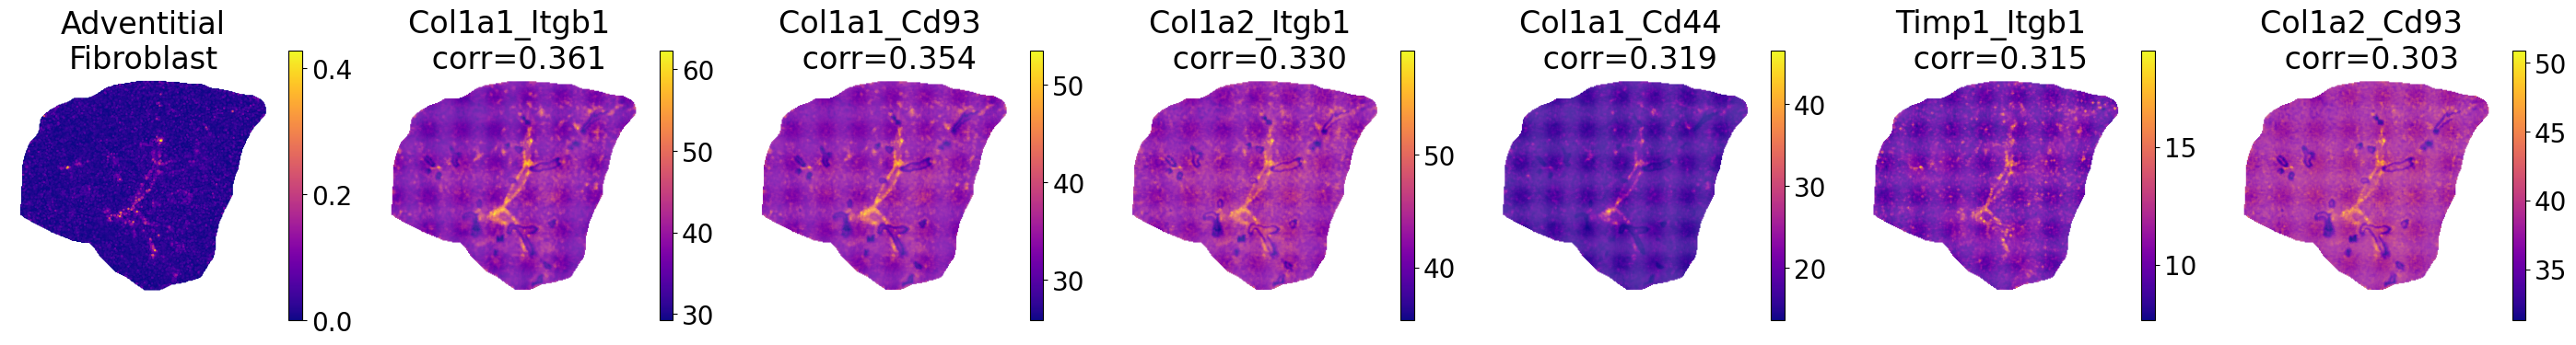

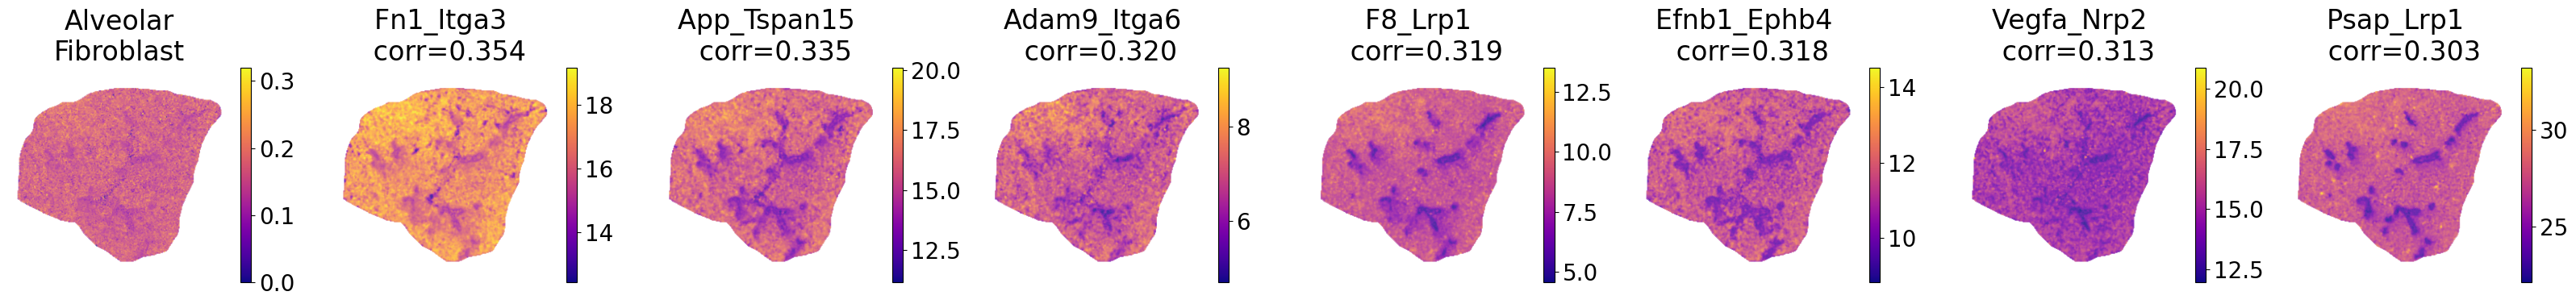

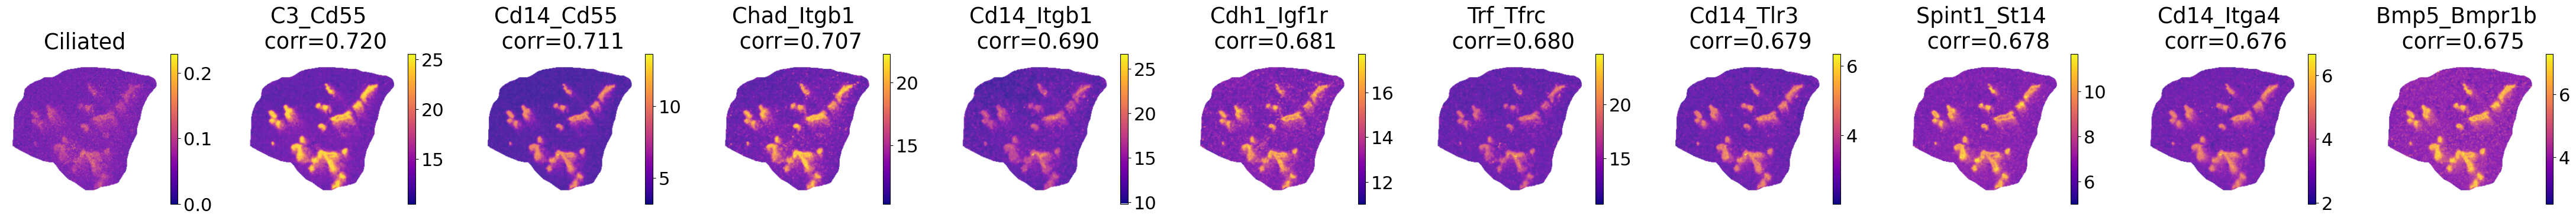

In [14]:
# sample_name = 'D2'
# out_f = f'../input_datasets/{ds}/{sample_name}/'
# adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
# out_f = f'../datasets/{ds}/{sample_name}/'
# idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')

# svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)
# idata = idata[:, idata.var['is_svi']==1]
# adata.obs[['row', 'col']] = adata.obs[['row', 'col']].astype(int)
# adata, adata_lri, adata_pattern = op.cell_transform(idata, adata, label=adata.uns['cluster_key'])
# adata_lri.obs[['row', 'col']] = adata_lri.obs[['row', 'col']].astype(int)
# adata_pattern.obs[['row', 'col']] = adata_pattern.obs[['row', 'col']].astype(int)

out_f = f'../input_datasets/{ds}/{sample_name}/'
decon = pd.read_csv(f'{out_f}/decon.csv', index_col=0)
corr_df = pd.concat([decon.T, adata_lri.to_df().loc[decon.columns]], axis=1).corr(method='pearson')
corr_df_asyn =  corr_df.loc[adata_lri.var_names, decon.index]
mask = corr_df_asyn.loc[corr_df_asyn.idxmax()].to_numpy().diagonal() > 0.3
decon_meta = pd.concat([decon.T, adata_lri.obs.loc[decon.columns]], axis=1)
decon_meta[['row', 'col']] = decon_meta[['row', 'col']].astype(int)

plt.rcParams.update({'font.size': 20})

corrs = corr_df_asyn[corr_df_asyn['Adventitial Fibroblast']>0.3]['Adventitial Fibroblast'].sort_values(ascending=False).values[:10]
lris = corr_df_asyn[corr_df_asyn['Adventitial Fibroblast']>0.3]['Adventitial Fibroblast'].sort_values(ascending=False).index[:10]
marker_score = adata_lri.to_df().loc[decon.columns, lris]

plt.figure(figsize=(44, 4))
base=1
plt.subplot(1, 11, base)
cell_meta_sub=decon_meta[decon_meta['Adventitial Fibroblast']>0].sort_values('Adventitial Fibroblast')
im=plt.scatter(decon_meta['row'],decon_meta['col'], c=decon_meta['Adventitial Fibroblast'], s=1, cmap='plasma',vmin=0, edgecolors='none')
plt.scatter(cell_meta_sub['row'],cell_meta_sub['col'], c=cell_meta_sub['Adventitial Fibroblast'], s=3, cmap='plasma',vmin=0, edgecolors='none')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.axis('equal')
plt.axis('off')
plt.title(f'Adventitial\nFibroblast', y=0.9)
base+=1
for i in range(len(lris)):
    plt.subplot(1, 11, base)
    im=plt.scatter(decon_meta['row'],decon_meta['col'], c=marker_score[lris[i]], s=1, cmap='plasma', edgecolors='none')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{lris[i]} \n corr={"%.3f" % corrs[i]}', y=0.9)
    base += 1
plt.tight_layout()
plt.savefig(f'../figures/{ds}_{sample_name}_AdventitialFibroblast.png', dpi=100,bbox_inches='tight')

plt.rcParams.update({'font.size': 20})

corrs = corr_df_asyn[corr_df_asyn['Alveolar Fibroblast']>0.3]['Alveolar Fibroblast'].sort_values(ascending=False).values[:10]
lris = corr_df_asyn[corr_df_asyn['Alveolar Fibroblast']>0.3]['Alveolar Fibroblast'].sort_values(ascending=False).index[:10]
marker_score = adata_lri.to_df().loc[decon.columns, lris]

plt.figure(figsize=(44, 4))
base=1
plt.subplot(1, 11, base)
im=plt.scatter(decon_meta['row'],decon_meta['col'], c=decon_meta['Alveolar Fibroblast'], s=0.05, cmap='plasma',vmin=0)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.axis('equal')
plt.axis('off')
plt.title(f'Alveolar\nFibroblast')
base+=1
for i in range(len(lris)):
    plt.subplot(1, 11, base)
    im=plt.scatter(decon_meta['row'],decon_meta['col'], c=marker_score[lris[i]], s=0.05, cmap='plasma')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{lris[i]} \n corr={"%.3f" % corrs[i]}')
    base += 1
plt.tight_layout()
plt.savefig(f'../figures/{ds}_{sample_name}_AlveolarFibroblast.png', dpi=100,bbox_inches='tight')

plt.rcParams.update({'font.size': 22})

corrs = corr_df_asyn[corr_df_asyn['Ciliated']>0.3]['Ciliated'].sort_values(ascending=False).values[:10]
lris = corr_df_asyn[corr_df_asyn['Ciliated']>0.3]['Ciliated'].sort_values(ascending=False).index[:10]
marker_score = adata_lri.to_df().loc[decon.columns, lris]

plt.figure(figsize=(44, 4))
base=1
plt.subplot(1, 11, base)
im=plt.scatter(decon_meta['row'],decon_meta['col'], c=decon_meta['Ciliated'], s=0.05, cmap='plasma',vmin=0)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.axis('equal')
plt.axis('off')
plt.title(f'Ciliated')
base+=1
for i in range(len(lris)):
    plt.subplot(1, 11, base)
    im=plt.scatter(decon_meta['row'],decon_meta['col'], c=marker_score[lris[i]], s=0.05, cmap='plasma')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{lris[i]} \n corr={"%.3f" % corrs[i]}')
    base += 1
plt.tight_layout()
plt.savefig(f'../figures/{ds}_{sample_name}_Ciliated.png', dpi=100,bbox_inches='tight')

In [ ]:
from PIL import Image

def combine_images_grid(image_paths, rows=3, cols=3):

  images = [Image.open(path) for path in image_paths]

  widths, heights = zip(*(i.size for i in images))

  # Calculate dimensions
  grid_width = max(widths) * cols  
  grid_height = max(heights) * rows

  new_image = Image.new('RGB', (grid_width, grid_height), (255,255,255))

  x_offset = 0
  y_offset = 0
  max_y = -1

  for i, image in enumerate(images):
    new_image.paste(image, (x_offset, y_offset))
    if max_y < image.size[1]:
        max_y = image.size[1]
    x_offset += image.size[0]
    if (i+1) % cols == 0:
      x_offset = 0
      y_offset += max_y
      max_y = -1

  return new_image

# image_paths = []
# for input1 in range(len(data_sets)):
#     sample_name = data_sets[input1]
#     image_paths.append(f'../figures/{ds}_{sample_name}_metric.png')

In [10]:
image_paths = [
    f'../figures/mouse_lung_D2_Cluster_5.png', f'../figures/mouse_lung_E4_Cluster_1.png', f'../figures/mouse_lung_E5_Cluster_1.png',
]
combined_image = combine_images_grid(image_paths, rows=3, cols=1)
combined_image.save(f'../merged_figures/{ds}_Cluster511.png')


In [11]:
image_paths = [
    f'../figures/mouse_lung_D2_Cluster_4.png', f'../figures/mouse_lung_D2_Cluster_6.png', f'../figures/mouse_lung_E4_Cluster_5.png', f'../figures/mouse_lung_E4_Cluster_6.png',
    f'../figures/mouse_lung_E5_Cluster_2.png', f'../figures/mouse_lung_E5_Cluster_4.png', f'../figures/mouse_lung_E5_Cluster_5.png',
]
combined_image = combine_images_grid(image_paths, rows=len(image_paths), cols=1)
combined_image.save(f'../merged_figures/{ds}_clusters_other.png')

In [15]:
image_paths = [
    f'../figures/{ds}_D2_AdventitialFibroblast.png', f'../figures/{ds}_D2_Ciliated.png',  f'../figures/{ds}_D2_AlveolarFibroblast.png', 
]
combined_image = combine_images_grid(image_paths, rows=len(image_paths), cols=1)
combined_image.save(f'../merged_figures/{ds}_D2_marker.png')

In [16]:
image_paths = [
    f'../figures/{ds}_D2_BronchioliMarker.png', f'../figures/{ds}_E4_BronchioliMarker.png',  f'../figures/{ds}_E5_BronchioliMarker.png', 
]
combined_image = combine_images_grid(image_paths, rows=len(image_paths), cols=1)
combined_image.save(f'../merged_figures/{ds}_bro_marker.png')

In [ ]:
image_paths = [
    f'../figures/{ds}_D2_BronchioliMarker.png', f'../figures/{ds}_E4_BronchioliMarker.png',  f'../figures/{ds}_E5_BronchioliMarker.png', 
]
combined_image = combine_images_grid(image_paths, rows=len(image_paths), cols=1)
combined_image.save(f'../merged_figures/{ds}_bro_marker.png')

In [11]:

data_sets = os.listdir(f'../datasets/{ds}/')

image_paths = []
for input1 in range(len(data_sets)):
    sample_name = data_sets[input1]
    image_paths.append(f'../figures/{ds}_{sample_name}_pattern_metric.png')
for input1 in range(len(data_sets)):
    sample_name = data_sets[input1]
    image_paths.append(f'../figures/{ds}_{sample_name}_label_pattern.png')

combined_image = combine_images_grid(image_paths, rows=1, cols=6)
combined_image.save(f'../merged_figures/{ds}_pattern_metric_combined.png')

image_paths = [f'../merged_figures/{ds}_pattern_metric_combined.png']
for input1 in range(len(data_sets)):
    sample_name = data_sets[input1]
    image_paths.append(f'../figures/{ds}_{sample_name}_patterns1.png')

combined_image = combine_images_grid(image_paths, rows=4, cols=1)
combined_image.save(f'../merged_figures/{ds}_patterns_combined.png')

In [4]:
data_sets = os.listdir(f'../datasets/{ds}/')
image_paths = []
for input1 in range(len(data_sets)):
    sample_name = data_sets[input1]
    image_paths.append(f'../figures/{ds}_{sample_name}_relation.png')
combined_image = combine_images_grid(image_paths, rows=2, cols=3)
combined_image.save(f'../merged_figures/mouse_lung_relation_combined.png')

image_paths = []
for input1 in range(len(data_sets)):
    sample_name = data_sets[input1]
    image_paths.append(f'../figures/{ds}_{sample_name}_relation_enrichment.png')
combined_image = combine_images_grid(image_paths, rows=2, cols=3)
combined_image.save(f'../merged_figures/mouse_lung_relation_enrichment_combined.png')

NameError: name 'combine_images_grid' is not defined